This is model 1.0.0.29 trained on dataset 8 classifying to all five categories. The model was actually trained on a Google Cloud instance with GPU as it was far too computationally expensive to train on my laptop. When training the metrics were saved to disk and those are used for the plots below. Metrics were also logged to TensorBoard. Those logs as well as the resulting model are included in the repository.

In [1]:
import numpy as np
import os
import wget
import tensorflow as tf
from training_utils import download_file, get_batches, read_and_decode_single_example, load_validation_data, \
    download_data, evaluate_model, get_training_data, load_weights, flatten
import matplotlib.pyplot as plt
import math
%matplotlib inline
#import argparse
from tensorboard import summary as summary_lib

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Function to do the data augmentation on the GPU instead of the CPU, doing it on the CPU significantly slowed down training
# Taken from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
def augment(images, labels,
            horizontal_flip=False,
            vertical_flip=False,
            #rotate=0,  # Maximum 90 degrees rotations
            mixup=0):  # Mixup coeffecient, see https://arxiv.org/abs/1710.09412.pdf

    # My experiments showed that casting on GPU improves training performance
    if images.dtype != tf.float32:
        images = tf.image.convert_image_dtype(images, dtype=tf.float32)
        # images = tf.subtract(images, 0.5)
        # images = tf.multiply(images, 2.0)
    #labels = tf.to_float(labels)

    with tf.name_scope('augmentation'):
        shp = tf.shape(images)
        batch_size, height, width = shp[0], shp[1], shp[2]
        width = tf.cast(width, tf.float32)
        height = tf.cast(height, tf.float32)

        # The list of affine transformations that our image will go under.
        # Every element is Nx8 tensor, where N is a batch size.
        transforms = []
        identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
        if horizontal_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            flip_transform = tf.convert_to_tensor(
                [-1., 0., width, 0., 1., 0., 0., 0.], dtype=tf.float32)
            transforms.append(
                tf.where(coin,
                         tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),
                         tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if vertical_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            flip_transform = tf.convert_to_tensor(
                [1, 0, 0, 0, -1, height, 0, 0], dtype=tf.float32)
            transforms.append(
                tf.where(coin,
                         tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),
                         tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if transforms:
            images = tf.contrib.image.transform(
                images,
                tf.contrib.image.compose_transforms(*transforms),
                interpolation='BILINEAR')  # or 'NEAREST'

        def cshift(values):  # Circular shift in batch dimension
            return tf.concat([values[-1:, ...], values[:-1, ...]], 0)

        if mixup > 0:
            beta = tf.distributions.Beta(mixup, mixup)
            lam = beta.sample(batch_size)
            ll = tf.expand_dims(tf.expand_dims(tf.expand_dims(lam, -1), -1), -1)
            images = ll * images + (1 - ll) * cshift(images)
            labels = lam * labels + (1 - lam) * cshift(labels)

    return images, labels

In [3]:
# arguments
epochs = 35
dataset = 9
init_model = None
how = "normal"
action = "train"
threshold = 0.5

In [4]:
# download the data
#download_data(what=dataset)
batch_size = 32
train_files, total_records = get_training_data(what=dataset)

In [5]:
## Hyperparameters
epsilon = 1e-8

# learning rate
epochs_per_decay = 10
starting_rate = 0.001
decay_factor = 0.80
staircase = True

# learning rate decay variables
steps_per_epoch = int(total_records / batch_size)
print("Steps per epoch:", steps_per_epoch)

# lambdas
lamC = 0.00001
lamF = 0.00250

mu = 104

# use dropout
dropout = True
fcdropout_rate = 0.5
convdropout_rate = 0.001
pooldropout_rate = 0.1

if how == "label":
    num_classes = 5
elif how == "normal":
    num_classes = 2
elif how == "mass":
    num_classes = 3
elif how == "benign":
    num_classes = 3

print("Number of classes:", num_classes)

config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.6

Steps per epoch: 1366
Number of classes: 2


In [6]:
model_name = "model_s1.0.0.29l.14"
## Change Log
# 0.0.0.4 - increase pool3 to 3x3 with stride 3
# 0.0.0.6 - reduce pool 3 stride back to 2
# 0.0.0.7 - reduce lambda for l2 reg
# 0.0.0.8 - increase conv1 to 7x7 stride 2
# 0.0.0.9 - disable per image normalization
# 0.0.0.10 - commented out batch norm in conv layers, added conv4 and changed stride of convs to 1, increased FC lambda
# 0.0.0.11 - turn dropout for conv layers on
# 0.0.0.12 - added batch norm after pooling layers, increase pool dropout, decrease conv dropout, added extra conv layer to reduce data dimensionality
# 0.0.0.13 - added precision and f1 summaries
# 0.0.0.14 - fixing batch normalization, I don't think it's going to work after each pool
# 0.0.0.15 - reduced xentropy weighting term
# 0.0.0.17 - replaced initial 5x5 conv layers with 3 3x3 layers
# 0.0.0.18 - changed stride of first conv to 2 from 1
# 0.0.0.19 - doubled units in two fc layers
# 0.0.0.20 - lowered learning rate, put a batch norm back in
# 0.0.0.21 - put all batch norms back in
# 0.0.0.22 - increased lambdaC, removed dropout from conv layers
# 1.0.0.23 - added extra conv layers
# 1.0.0.27 - updates to training code and metrics
# 1.0.0.28 - using weighted x-entropy to improve recall
# 1.0.0.29 - updated code to work training to classify for multiple classes
# 1.0.0.29f - putting weighted x-entropy back

graph = tf.Graph()
with graph.as_default():
    training = tf.placeholder(dtype=tf.bool, name="is_training")
    is_testing = tf.placeholder(dtype=bool, shape=(), name="is_testing")

    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(starting_rate,
                                               global_step,
                                               steps_per_epoch * epochs_per_decay,
                                               decay_factor,
                                               staircase=staircase)

    with tf.name_scope('inputs') as scope:
        image, label = read_and_decode_single_example(train_files, label_type=how, normalize=False)

        X_def, y_def = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=2000,
                                              min_after_dequeue=1000)

        # Placeholders
        X = tf.placeholder_with_default(X_def, shape=[None, 299, 299, 1])
        y = tf.placeholder_with_default(y_def, shape=[None])
        
        X_adj = tf.image.adjust_contrast(X, 2.0)
        X_adj = tf.cast(X_adj, dtype=tf.float32)

        # center the pixel data
        mu = tf.constant(127.0, name="pixel_mean", dtype=tf.float32)
        X_adj = tf.subtract(X_adj, mu, name="centered_input")

        # scale the data
        X_adj = tf.divide(X_adj, 255.0)
        
        X_adj, y = augment(X_adj, y, horizontal_flip=True, vertical_flip=True, mixup=0)
    # Convolutional layer 1
    with tf.name_scope('conv1') as scope:
        conv1 = tf.layers.conv2d(
            X_adj,  # Input data
            filters=32,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=100),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1'
        )

        conv1_bn = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        conv1_bn = tf.nn.relu(conv1_bn, name='relu1')
        
    print("Graph created...")

Instructions for updating:
Use the retry module or similar alternatives.
Graph created...


In [7]:
## CONFIGURE OPTIONS
# if we are initializing the weights from a pre-trained model make sure it exists
if init_model is not None:
    if os.path.exists(os.path.join("model", init_model + '.ckpt.index')):
        init = False
    else:
        init = True
# otherwise if this model exists let's continue training it rather than reinitializing it
else:
    if os.path.exists(os.path.join("model", model_name + '.ckpt.index')):
        init = False
    else:
        init = True

meta_data_every = 1
log_to_tensorboard = True
print_every = 5  # how often to print metrics
checkpoint_every = 1  # how often to save model in epochs
use_gpu = False  # whether or not to use the GPU
print_metrics = True  # whether to print or plot metrics, if False a plot will be created and updated every epoch

config = tf.ConfigProto(device_count = {'GPU': 0})

Initializing model...
Training model model_s1.0.0.29l.14 ...


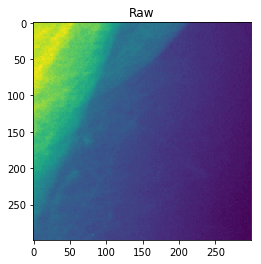

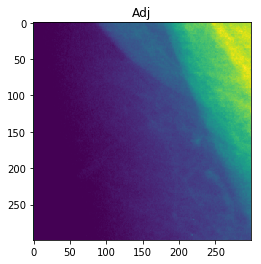


Train Raw Mean: 106.15787190579523
Train Raw Min: 0
Train Raw Max: 224
Train Raw Std: 39.69775572877064

Train Adj Mean: -0.08118102
Train Adj Min: -0.49803925
Train Adj Max: 0.5019608
Train Adj Std: 0.200746

Train C1 Mean: -0.00060820003
Train C1 Min: -0.14106955
Train C1 Max: 0.14170626
INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: inputs/input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/device:CPU:0"](inputs/input_producer, inputs/input_producer/RandomShuffle)]]


FileNotFoundError: [Errno 2] No such file or directory: 'data\\cv9_data.npy'

In [8]:
init = True
## train the model
with tf.Session(graph=graph, config=config) as sess:
    if log_to_tensorboard:
        train_writer = tf.summary.FileWriter('./logs/tr_' + model_name, sess.graph)
        test_writer = tf.summary.FileWriter('./logs/te_' + model_name)

    if not print_metrics:
        # create a plot to be updated as model is trained
        f, ax = plt.subplots(1, 4, figsize=(24, 5))

    # create the saver
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
    print("Initializing model...")

    # if we are training the model
    if action == "train":
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        print("Training model", model_name, "...")

        for epoch in range(2):
            sess.run(tf.local_variables_initializer())

            for i in range(steps_per_epoch):
                # create the metadata
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()

            
                image_batch, image_batch_adj, conv1_batch = sess.run(
                    [X, X_adj, conv1],
                    feed_dict={
                        training: True,
                    },
                    options=run_options,
                    run_metadata=run_metadata)
                
                image_arr = np.array(image_batch)
                image_arr_adj = np.array(image_batch_adj)
                
                conv1_batch = np.array(conv1_batch)
                plt.imshow(image_arr[0].reshape([299,299]))
                plt.title("Raw")
                plt.show()
                
                conv1_batch = np.array(conv1_batch)
                plt.imshow(image_arr_adj[0].reshape([299,299]))
                plt.title("Adj")
                plt.show()
                
                print()
                print("Train Raw Mean:", np.mean(image_arr))
                print("Train Raw Min:", np.min(image_arr))
                print("Train Raw Max:", np.max(image_arr))
                print("Train Raw Std:", np.std(image_arr))
                print()
                print("Train Adj Mean:", np.mean(image_arr_adj))
                print("Train Adj Min:", np.min(image_arr_adj))
                print("Train Adj Max:", np.max(image_arr_adj))
                print("Train Adj Std:", np.std(image_arr_adj))
                print()
                print("Train C1 Mean:", np.mean(conv1_batch))
                print("Train C1 Min:", np.min(conv1_batch))
                print("Train C1 Max:", np.max(conv1_batch))
                break
            
            # initialize the local variables so we have metrics only on the evaluation
            sess.run(tf.local_variables_initializer())

            # load the test data
            X_cv, y_cv = load_validation_data(percentage=1, how=how, which=dataset)

            # evaluate the test data
            for X_batch, y_batch in get_batches(X_cv, y_cv, batch_size, distort=False):
                cv_image_batch, cv_image_batch_adj, cv_conv1_batch = sess.run(
                    [X, X_adj, conv1],
                    feed_dict={
                        X: X_batch,
                        y: y_batch,
                        training: False
                    })
                break
            
            cv_image_arr = np.array(cv_image_batch)
            cv_image_arr_adj = np.array(cv_image_batch_adj)
            cv_conv1_batch = np.array(cv_conv1_batch)
#             plt.imshow(cv_image_arr[0].reshape([299,299]))
#             plt.show()
            
            print()    
            print("CV Raw Mean:", np.mean(cv_image_arr))
            print("CV Raw Min:", np.min(cv_image_arr))
            print("CV Raw Max:", np.max(cv_image_arr))
            print("CV Raw Std:", np.std(cv_image_arr))
            print()
            print("CV Adj Mean:", np.mean(cv_image_arr_adj))
            print("CV Adj Min:", np.min(cv_image_arr_adj))
            print("CV Adj Max:", np.max(cv_image_arr_adj))
            print("CV Adj Std:", np.std(cv_image_arr_adj))
            print()
            print("CV C1 Mean:", np.mean(cv_conv1_batch))
            print("CV C1 Min:", np.min(cv_conv1_batch))
            print("CV C1 Max:", np.max(cv_conv1_batch))
            
            # delete the test data to save memory
            del (X_cv)
            del (y_cv)

            print("Done evaluating...")

            break
    # stop the coordinator
    coord.request_stop()

    # Wait for threads to stop
    coord.join(threads)

In [ ]:
train_image = image_arr[0]
cv_image = cv_image_arr[0]

In [ ]:
print(np.mean(train_image))
print(np.mean(cv_image))